# Model Quantization

**Module 03 | Notebook 4 of 5**

Quantization reduces the numerical precision of model weights, significantly decreasing memory and improving speed.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand different precision formats (FP32, FP16, INT8)
2. Apply dynamic quantization with PyTorch
3. Use bitsandbytes for 4-bit/8-bit loading
4. Compare memory and speed improvements

---
### Prerequisites
- Basic understanding of gradients and weights
- Familiarity with PyTorch model loading
- (Optional) GPU for 4-bit/8-bit demos

---

In [1]:
%%capture
!pip install transformers torch accelerate bitsandbytes

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import time
import gc
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


---

## Understanding Numerical Precision

### Data Types in Deep Learning

```
FP32 (32-bit float):     ████████████████████████████████  (4 bytes)
FP16 (16-bit float):     ████████████████                  (2 bytes)
BF16 (bfloat16):         ████████████████                  (2 bytes)
INT8 (8-bit integer):    ████████                          (1 byte)
INT4 (4-bit integer):    ████                              (0.5 bytes)
```

### Precision Comparison

| Format | Bits | Range | Use Case |
|--------|------|-------|----------|
| **FP32** | 32 | ±3.4×10³⁸ | Training (default) |
| **FP16** | 16 | ±65,504 | Mixed precision training |
| **BF16** | 16 | ±3.4×10³⁸ | Same range as FP32, less precision |
| **INT8** | 8 | -128 to 127 | Inference |
| **INT4** | 4 | -8 to 7 | Aggressive compression |
### 🧠 Why Quantization Works

Deep learning models are remarkably robust to noise. We don't need 32-bit precision (7 decimal digits) for every weight. 
Quantization maps a continuous range of values to a smaller set of discrete values (bins).

- **Range**: The min/max values we can represent.
- **Precision**: The distance between two adjacent representable numbers.

> **Analogy**: Instead of measuring someone's height as 175.2341 cm (FP32), we measure it as 175 cm (INT8). For most purposes (like buying clothes), 175 cm is "close enough".

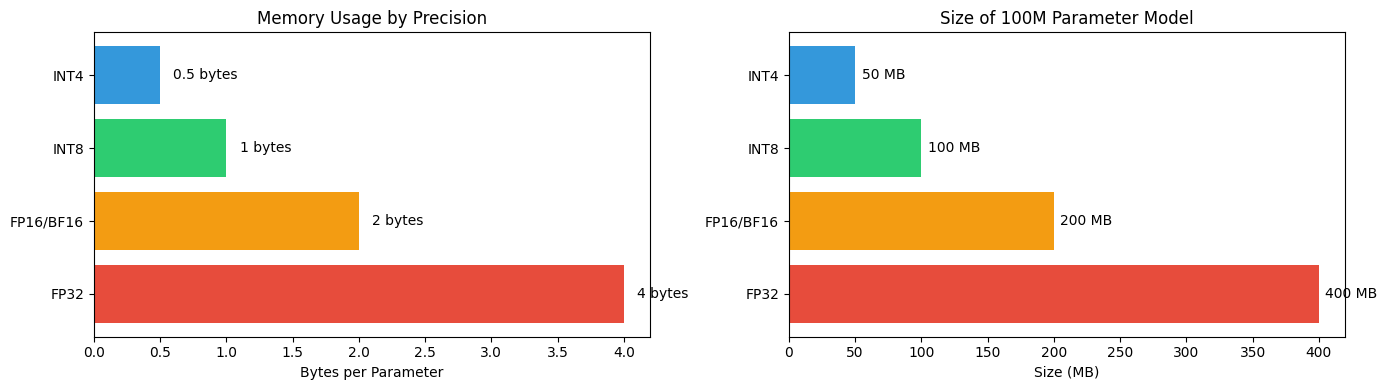

In [3]:
# Visualize precision
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Memory comparison
formats = ['FP32', 'FP16/BF16', 'INT8', 'INT4']
bytes_per = [4, 2, 1, 0.5]
colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']

axes[0].barh(formats, bytes_per, color=colors)
axes[0].set_xlabel('Bytes per Parameter')
axes[0].set_title('Memory Usage by Precision')
for i, v in enumerate(bytes_per):
    axes[0].text(v + 0.1, i, f'{v} bytes', va='center')

# Model size comparison (100M param model)
params = 100  # 100M parameters
sizes = [params * b for b in bytes_per]

axes[1].barh(formats, sizes, color=colors)
axes[1].set_xlabel('Size (MB)')
axes[1].set_title('Size of 100M Parameter Model')
for i, v in enumerate(sizes):
    axes[1].text(v + 5, i, f'{v:.0f} MB', va='center')

plt.tight_layout()
plt.show()

---

## Dynamic Quantization (INT8)

Dynamic quantization quantizes weights to INT8 while keeping activations in FP32.

**Best for:** CPU inference, RNN/LSTM models

In [4]:
# Load model in FP32
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_fp32 = AutoModelForSequenceClassification.from_pretrained(model_name)

# Count parameters and size
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size / (1024**2)  # MB

fp32_size = get_model_size(model_fp32)
print(f"FP32 Model Size: {fp32_size:.1f} MB")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

FP32 Model Size: 255.4 MB


In [5]:
# Apply dynamic quantization
# We only quantize Linear layers because they contain most of the parameters.
# dtype=torch.qint8 tells PyTorch to use 8-bit integers for weights.
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    {torch.nn.Linear},  # Layers to quantize
    dtype=torch.qint8   # Target precision
)

print("✅ Dynamic INT8 quantization applied!")

✅ Dynamic INT8 quantization applied!


In [6]:
# Compare sizes
int8_size = get_model_size(model_int8)

print(f"\nSize Comparison:")
print(f"  FP32: {fp32_size:.1f} MB")
print(f"  INT8: {int8_size:.1f} MB")
print(f"  Reduction: {(1 - int8_size/fp32_size)*100:.1f}%")


Size Comparison:
  FP32: 255.4 MB
  INT8: 91.0 MB
  Reduction: 64.4%


In [7]:
# Benchmark inference speed (CPU)
test_text = "This movie was absolutely fantastic! I loved every minute of it."
inputs = tokenizer(test_text, return_tensors="pt")

# Warmup
with torch.no_grad():
    _ = model_fp32(**inputs)
    _ = model_int8(**inputs)

# Benchmark
n_runs = 50

# FP32
start = time.time()
for _ in range(n_runs):
    with torch.no_grad():
        _ = model_fp32(**inputs)
fp32_time = (time.time() - start) / n_runs * 1000

# INT8
start = time.time()
for _ in range(n_runs):
    with torch.no_grad():
        _ = model_int8(**inputs)
int8_time = (time.time() - start) / n_runs * 1000

print(f"\nInference Latency (CPU, avg of {n_runs} runs):")
print(f"  FP32: {fp32_time:.2f} ms")
print(f"  INT8: {int8_time:.2f} ms")
print(f"  Speedup: {fp32_time/int8_time:.2f}x")


Inference Latency (CPU, avg of 50 runs):
  FP32: 58.86 ms
  INT8: 16.22 ms
  Speedup: 3.63x


In [8]:
# Verify outputs match
with torch.no_grad():
    fp32_logits = model_fp32(**inputs).logits
    int8_logits = model_int8(**inputs).logits

fp32_probs = torch.softmax(fp32_logits, dim=-1)
int8_probs = torch.softmax(int8_logits, dim=-1)

print(f"\nOutput Comparison:")
print(f"  FP32: POSITIVE={fp32_probs[0,1]:.4f}")
print(f"  INT8: POSITIVE={int8_probs[0,1]:.4f}")
print(f"  Max Difference: {torch.abs(fp32_probs - int8_probs).max():.6f}")


Output Comparison:
  FP32: POSITIVE=0.9999
  INT8: POSITIVE=0.9999
  Max Difference: 0.000019


---

## Half Precision (FP16/BF16)

Converting to half precision is the simplest optimization for GPU inference.

In [9]:
if torch.cuda.is_available():
    # Convert to FP16
    model_fp16 = model_fp32.half().to(device)
    
    # Move FP32 to GPU for fair comparison
    model_fp32_gpu = model_fp32.to(device)
    
    # Prepare inputs
    inputs_gpu = {k: v.to(device) for k, v in inputs.items()}
    inputs_fp16 = {k: v.to(device) for k, v in inputs.items()}
    
    # Benchmark
    n_runs = 100
    
    # Warmup
    with torch.no_grad():
        _ = model_fp32_gpu(**inputs_gpu)
        _ = model_fp16(**inputs_fp16)
    torch.cuda.synchronize()
    
    # FP32 GPU
    start = time.time()
    for _ in range(n_runs):
        with torch.no_grad():
            _ = model_fp32_gpu(**inputs_gpu)
    torch.cuda.synchronize()
    fp32_gpu_time = (time.time() - start) / n_runs * 1000
    
    # FP16 GPU
    start = time.time()
    for _ in range(n_runs):
        with torch.no_grad():
            _ = model_fp16(**inputs_fp16)
    torch.cuda.synchronize()
    fp16_time = (time.time() - start) / n_runs * 1000
    
    print(f"GPU Inference Latency (avg of {n_runs} runs):")
    print(f"  FP32: {fp32_gpu_time:.2f} ms")
    print(f"  FP16: {fp16_time:.2f} ms")
    print(f"  Speedup: {fp32_gpu_time/fp16_time:.2f}x")
    print(f"\nMemory saved: ~50% (half the bytes per parameter)")
else:
    print("GPU not available. FP16 benefits are most significant on GPU.")

GPU Inference Latency (avg of 100 runs):
  FP32: 3.50 ms
  FP16: 3.48 ms
  Speedup: 1.01x

Memory saved: ~50% (half the bytes per parameter)


---

## 4-bit Quantization with BitsAndBytes

For large language models, 4-bit quantization enables running on consumer hardware.

### What is NF4 (NormalFloat4)?

**NF4** is a data type specifically designed for weights that follow a **Normal (Gaussian) distribution**, which most neural network weights do.
It is distinct from standard 4-bit integers because its quantization bins are spaced based on quantiles of the Normal distribution, making it information-theoretically optimal for holding normally distributed data.

In [10]:
# Note: This requires a GPU and the bitsandbytes library
if torch.cuda.is_available():
    # Configure 4-bit quantization
    bnb_config_4bit = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",  # NormalFloat4
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True  # Nested quantization
    )
    
    # Configure 8-bit quantization
    bnb_config_8bit = BitsAndBytesConfig(
        load_in_8bit=True
    )
    
    print("BitsAndBytes configurations ready!")
    print("\n4-bit config:")
    print(f"  Quant type: NF4 (NormalFloat4)")
    print(f"  Compute dtype: FP16")
    print(f"  Double quantization: Enabled")
else:
    print("GPU required for bitsandbytes quantization")

BitsAndBytes configurations ready!

4-bit config:
  Quant type: NF4 (NormalFloat4)
  Compute dtype: FP16
  Double quantization: Enabled


In [11]:
# Example: Loading a model in 4-bit (using a small model for demo)
if torch.cuda.is_available():
    try:
        # Clean up memory
        gc.collect()
        torch.cuda.empty_cache()
        
        # Load in 4-bit
        model_4bit = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            quantization_config=bnb_config_4bit,
            device_map="auto"
        )
        
        print("✅ Model loaded in 4-bit!")
        print(f"Memory used: {torch.cuda.memory_allocated() / 1024**2:.0f} MB")
        
    except Exception as e:
        print(f"Error loading 4-bit model: {e}")
        print("This may require more GPU memory or updated bitsandbytes.")
else:
    print("Skipping 4-bit loading (GPU required)")

✅ Model loaded in 4-bit!
Memory used: 208 MB


---

## Quantization Comparison Summary

In [12]:
import pandas as pd

# Create comparison table
comparison = pd.DataFrame({
    'Method': ['FP32 (baseline)', 'FP16 (half precision)', 'INT8 (dynamic)', '8-bit (bitsandbytes)', '4-bit (bitsandbytes)'],
    'Size Reduction': ['0%', '50%', '~50%', '75%', '87.5%'],
    'Speed Improvement': ['1x', '1.5-2x', '2-3x (CPU)', '1-2x', '1x'],
    'Accuracy Impact': ['baseline', 'negligible', '<1%', '1-2%', '2-5%'],
    'Best For': ['Training', 'GPU inference', 'CPU inference', 'Large LLMs', 'Very large LLMs'],
    'Requires Training': ['N/A', 'No', 'No', 'No', 'No']
})

print("Quantization Methods Comparison:")
print("=" * 100)
print(comparison.to_string(index=False))

Quantization Methods Comparison:
               Method Size Reduction Speed Improvement Accuracy Impact        Best For Requires Training
      FP32 (baseline)             0%                1x        baseline        Training               N/A
FP16 (half precision)            50%            1.5-2x      negligible   GPU inference                No
       INT8 (dynamic)           ~50%        2-3x (CPU)             <1%   CPU inference                No
 8-bit (bitsandbytes)            75%              1-2x            1-2%      Large LLMs                No
 4-bit (bitsandbytes)          87.5%                1x            2-5% Very large LLMs                No


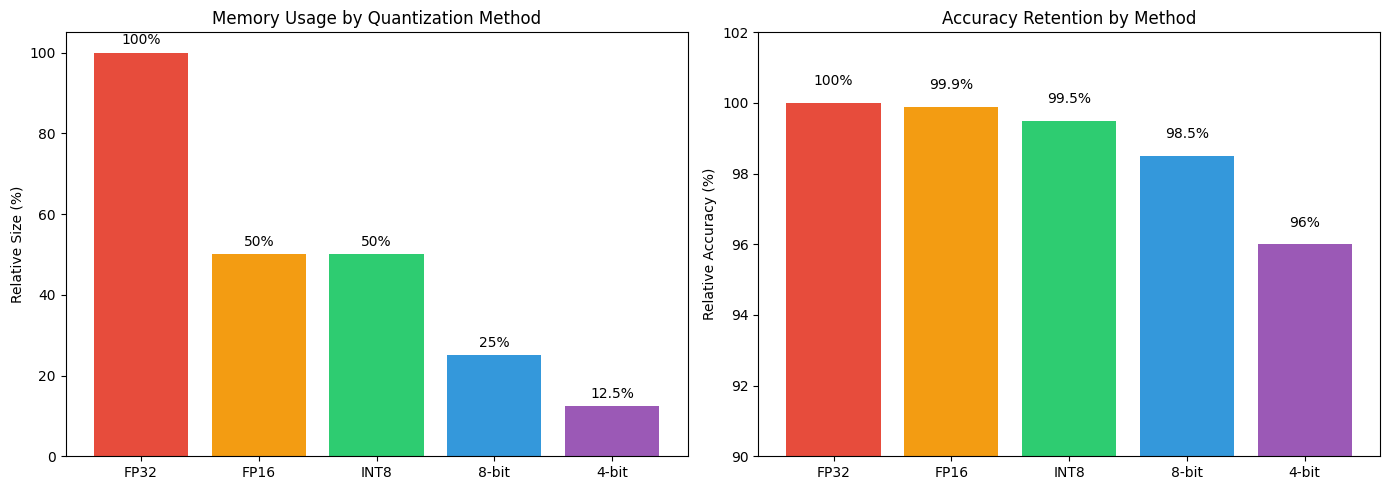

In [13]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['FP32', 'FP16', 'INT8', '8-bit', '4-bit']
sizes = [100, 50, 50, 25, 12.5]  # Relative sizes
accuracy = [100, 99.9, 99.5, 98.5, 96]  # Approximate relative accuracy

colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6']

# Size comparison
axes[0].bar(methods, sizes, color=colors)
axes[0].set_ylabel('Relative Size (%)')
axes[0].set_title('Memory Usage by Quantization Method')
for i, v in enumerate(sizes):
    axes[0].text(i, v + 2, f'{v}%', ha='center')

# Accuracy comparison
axes[1].bar(methods, accuracy, color=colors)
axes[1].set_ylabel('Relative Accuracy (%)')
axes[1].set_title('Accuracy Retention by Method')
axes[1].set_ylim(90, 102)
for i, v in enumerate(accuracy):
    axes[1].text(i, v + 0.5, f'{v}%', ha='center')

plt.tight_layout()
plt.show()

---

## Saving Quantized Models

In [15]:
import os

# Save the INT8 quantized model
save_path = "./quantized_model_int8"
os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist

torch.save(model_int8.state_dict(), f"{save_path}/model.pt")
tokenizer.save_pretrained(save_path)

print(f"INT8 model saved to {save_path}")

INT8 model saved to ./quantized_model_int8


---

## 🎯 Student Challenge

### Challenge: Quantization Accuracy Study

In [ ]:
# TODO: Evaluate quantized models on a test set

# 1. Load the SST-2 validation set
# 2. Evaluate FP32, INT8, and FP16 models
# 3. Create a table comparing:
#    - Accuracy
#    - Inference time
#    - Memory usage

# from datasets import load_dataset
# dataset = load_dataset("glue", "sst2")

# Your solution:


---

## Key Takeaways

1. **Quantization reduces precision** to save memory and speed up inference
2. **FP16/BF16** is the easiest optimization with minimal accuracy loss
3. **Dynamic INT8** works well for CPU inference
4. **4-bit quantization** enables large models on consumer hardware
5. **Trade-off exists** between size reduction and accuracy

---

## Next Steps

Continue to `05_benchmarking.ipynb` to compare all optimization techniques!